### Классы для распределений и каналов

In [74]:
from scipy.optimize import minimize
from numpy.typing import NDArray
import numpy as np
import math

ProbVector = NDArray[np.float64]        # вектор распределения случайной величины p(x_i)
CondProbMatrix = NDArray[np.float64]    # матрица условных вероятностей p(y_i|x_j), где i - индекс строки, j - столбца

# Класс, задающий распределение случайной величины
class Distribution:
    def __init__(self, p : ProbVector):
        if not np.isclose(np.sum(p), 1):
            raise ValueError("Sum of probabilities should be equals to 1.")
        if np.any(p < 0):
            raise ValueError("Probabilities should be non-negative value.")
        self.p = p

    def get_entropy(self):
        p = self.p[self.p > 0] # p*log(p) = 0 if p is 0
        return -float(np.sum(p * np.log2(p)))

    def __repr__(self):
        items = [f"p({id})={p:.3f}" for id, p in enumerate(self.p)]
        return "{" + ", ".join(items) + "}"

# Класс, задающий распределение случайной величины с именованными исходами
class NamedDistribution(Distribution):
    def __init__(self, p: ProbVector, names: list[str]):
        if len(names) != len(p):
            raise ValueError("Length of names list must match length of probability vector.")
        super().__init__(p)
        self.names = names

    def __repr__(self):
        items = [f"p({name})={p:.3f}" for name, p in zip(self.names, self.p)]
        return "{" + ", ".join(items) + "}"

    def get_probability_of(self, name: str):
        if name not in self.names:
            raise ValueError(f"Name [{name}] not in distribution.")
        index = self.names.index(name)
        return float(self.p[index])

# вычисление энтропии распределения X
def H(X : Distribution):
    return X.get_entropy()

# двоичная энтропия
def h(p : float):
    if np.isclose(p, 0):
        return 0
    return -p*math.log2(p) - (1 - p)*math.log2(1 - p)

# q-ичная энтропия
def hq(q : int, p : float):
    if np.isclose(p, 0):
        return 0
    return -p*math.log2(p/(q - 1)) - (1 - p)*math.log2(1 - p)

# вычисление энтропии H(Y|X)
def condH(YlX : CondProbMatrix, X : Distribution):
    H_Yx= np.array([ # H(Y|X=x) for fixed x
        -np.sum(p_Ylx[p_Ylx > 0] * np.log2(p_Ylx[p_Ylx > 0])) for p_Ylx in YlX.T
    ])
    return float(np.dot(X.p, H_Yx))

# дискретный канал, заданный через условные(переходные) вероятности p(y|x)
# и имена исходов для выходной случайной величичны Y
class Channel:
    def __init__(self, p_YlX : CondProbMatrix, Y_names : list[str] | None = None):
        if np.any(p_YlX < 0):
            raise ValueError("Probabilities should be non-negative.")
        if not np.allclose(p_YlX.sum(axis=0), 1):
            raise ValueError("Each column of p_YlX should sum to 1.")
        self.p_YlX = p_YlX
        if (Y_names is not None) and (len(Y_names) != p_YlX.shape[0]):
            raise ValueError("Length of Y_names should match number of rows in p_YlX.")
        self.Y_names = Y_names

    # вычисление выходного распределения
    def get_Y(self, X : Distribution):
        if self.Y_names is not None:
            return NamedDistribution(self.p_YlX @ X.p, self.Y_names)
        else:
            return Distribution(self.p_YlX @ X.p)

    # вычисление взаимной информации
    def get_I(self, X : Distribution):
        return H(self.get_Y(X)) - condH(self.p_YlX, X)

    # вычисление пропускной способности
    def get_C(self):
        # initial distribution is uniform
        N = self.p_YlX.shape[1]
        X0 = np.full(N, 1.0 / N)
        # constraints and bounds
        constraints = ({'type': 'eq', 'fun': lambda p: np.sum(p) - 1.0},)
        bounds = [(0.0, 1.0)] * N
        # function
        def negI(pVec):
            pVec = np.maximum(pVec, 0.0)
            pVec = pVec / np.sum(pVec) # normalize
            return -self.get_I(Distribution(pVec))
        # optimize and return
        res = minimize(negI, X0, method="SLSQP", bounds=bounds, constraints=constraints, options={'ftol':1e-12, 'maxiter':1000})
        if not res.success: # это выпуклая задача, но осечки всегда бывают
            raise RuntimeError("Warning: optimizer did not converge:", res.message)
        p_opt = np.maximum(res.x, 0.0)
        p_opt = p_opt / np.sum(p_opt)
        X_opt = Distribution(p_opt)
        C = self.get_I(X_opt)
        return C, X_opt

### Рассмотрим каналы с изветными результатами

In [75]:
from IPython.display import display, Markdown # type: ignore for Markdown

# двоичный симметричный канал c вероятность ошибки p
class BSC(Channel):
    def __init__(self, p : float):
        super().__init__(np.array([
            [1-p, p],
            [p, 1-p]
        ]))
        self.p = p

# двоичный канал со стиранием, где p(z) = p
class BEC(Channel):
    def __init__(self, p : float):
        super().__init__(np.array([
            [1-p, 0],
            [0, 1-p],
            [p, p]
        ]), ["0", "1", "z"])
        self.p = p

# q-ичный симметричный канал c вероятность ошибки p
class QSC(Channel):
    def __init__(self, q : int, p : float):
        super().__init__(np.array([[1-p if i == j else p/(q - 1) for j in range(q)] for i in range(q)]))
        self.q = q
        self.p = p

def do_channel_analysis_first_part(channel : Channel, X : Distribution):
    print(f"Пусть входное распределение X = {X} с энтропией H(X) = {H(X)} бит")
    Y = channel.get_Y(X)
    print(f"Тогда на выходе получаем Y = {Y}")
    print(f"Взаимная информация I(X,Y) = {channel.get_I(X):.3f} бит")
    return Y

def do_channel_analysis_second_part(channel : Channel):
    C, X_opt = channel.get_C()
    print(f"Пропускная способность C = {C:.3f} бит достигается на распределении X = {X_opt}")
    return X_opt

################################################### Анализ каналов ###################################################

p1 = 0.1
X = Distribution(np.array([1 - p1, p1]))

channel = BSC(0.1)
display(Markdown(f"1. Двоичный симметричный канал(p = {channel.p}):"))
Y = do_channel_analysis_first_part(channel, X)
print(f"Что совпадает с ожиданием I(X,Y) = H(Y) - h(p) = {H(Y) - h(channel.p):.3f} бит")
do_channel_analysis_second_part(channel)
print(f"Что совпадает с ожиданием C = 1 - h(p) = {1 - h(channel.p):.3f} бит")

channel = BEC(0.1)
display(Markdown(f"2. Двоичный канал со стиранием(p = {channel.p}):"))
Y = do_channel_analysis_first_part(channel, X)
print(f"Что совпадает с ожиданием I(X,Y) = H(Y) - h(p) = {H(Y) - h(channel.p):.3f} бит")
do_channel_analysis_second_part(channel)
print(f"Что совпадает с ожиданием C = 1 - p = {1 - channel.p:.3f} бит")

channel = QSC(5, 0.1)
X = Distribution(np.array([1 - p1, 0.25*p1, 0.2*p1, 0.15*p1, 0.4*p1]))
display(Markdown(f"3. q-ичный симметричный канал(q = {channel.q}, p = {channel.p}):"))
Y = do_channel_analysis_first_part(channel, X)
print(f"Что совпадает с ожиданием I(X,Y) = H(Y) - h_q(p) = {H(Y) - hq(channel.q, channel.p):.3f} бит")
do_channel_analysis_second_part(channel)
print(f"Что совпадает с ожиданием C = log_2(q) - h_q(p) = {math.log2(channel.q) - hq(channel.q, channel.p):.3f} бит")

1. Двоичный симметричный канал(p = 0.1):

Пусть входное распределение X = {p(0)=0.900, p(1)=0.100} с энтропией H(X) = 0.4689955935892812 бит
Тогда на выходе получаем Y = {p(0)=0.820, p(1)=0.180}
Взаимная информация I(X,Y) = 0.211 бит
Что совпадает с ожиданием I(X,Y) = H(Y) - h(p) = 0.211 бит
Пропускная способность C = 0.531 бит достигается на распределении X = {p(0)=0.500, p(1)=0.500}
Что совпадает с ожиданием C = 1 - h(p) = 0.531 бит


2. Двоичный канал со стиранием(p = 0.1):

Пусть входное распределение X = {p(0)=0.900, p(1)=0.100} с энтропией H(X) = 0.4689955935892812 бит
Тогда на выходе получаем Y = {p(0)=0.810, p(1)=0.090, p(z)=0.100}
Взаимная информация I(X,Y) = 0.422 бит
Что совпадает с ожиданием I(X,Y) = H(Y) - h(p) = 0.422 бит
Пропускная способность C = 0.900 бит достигается на распределении X = {p(0)=0.500, p(1)=0.500}
Что совпадает с ожиданием C = 1 - p = 0.900 бит


3. q-ичный симметричный канал(q = 5, p = 0.1):

Пусть входное распределение X = {p(0)=0.900, p(1)=0.025, p(2)=0.020, p(3)=0.015, p(4)=0.040} с энтропией H(X) = 0.659365763195016 бит
Тогда на выходе получаем Y = {p(0)=0.812, p(1)=0.047, p(2)=0.043, p(3)=0.038, p(4)=0.060}
Взаимная информация I(X,Y) = 0.398 бит
Что совпадает с ожиданием I(X,Y) = H(Y) - h_q(p) = 0.398 бит
Пропускная способность C = 1.653 бит достигается на распределении X = {p(0)=0.200, p(1)=0.200, p(2)=0.200, p(3)=0.200, p(4)=0.200}
Что совпадает с ожиданием C = log_2(q) - h_q(p) = 1.653 бит


### **Вывод**: мы получили ожидаемые результаты, и теперь можно попробовать применить эти методы к каналам, для которых аналитическое вычисление емкостей сильно осложнено.

4. Пуассновоский канал

$$p(y|x) = \frac{x^y}{A(x)y!}, A(x) = \sum\limits_y \frac{x^y}{y!}$$

Им можно моделировать лазер, когда на вход приходит $\sim x$ фотонов, а на выходе их оказывается $\sim y$.

In [76]:
from scipy.special import factorial

# Пуассоновский канал с максимальным числом фотонов q
class PoissonChannel(Channel):
    def __init__(self, q : int):
        N = q + 1
        A = [sum([(x**y)/factorial(y) for y in range(N)]) for x in range(N)]
        super().__init__(np.array([[(x**y)/(A[x]*factorial(y)) for x in range(N)] for y in range(N)]))
        self.q = q

channel = PoissonChannel(5)
X = Distribution(np.array([0.5, 0.3, 0.2, 0, 0, 0]))
Y = do_channel_analysis_first_part(channel, X)

Пусть входное распределение X = {p(0)=0.500, p(1)=0.300, p(2)=0.200, p(3)=0.000, p(4)=0.000, p(5)=0.000} с энтропией H(X) = 1.4854752972273344 бит
Тогда на выходе получаем Y = {p(0)=0.638, p(1)=0.165, p(2)=0.110, p(3)=0.055, p(4)=0.023, p(5)=0.008}
Взаимная информация I(X,Y) = 0.572 бит


Мы видим, что $p_Y(5) = 0.008 > 0$, это можно объяснить тем, что x - нужно воспринимать скорее не как количество фотонов, а как интенсивность(среднее количество в единицу времени).

Найдём пропускную способность в случае, когда на вход попадает не более 5 фотонов:

In [77]:
channel = PoissonChannel(5)
X_opt = do_channel_analysis_second_part(channel)
Y_opt = channel.get_Y(X_opt)
print(f"При этом Y = {Y_opt}")
print(f"H(X) = {H(X_opt)} бит")
print(f"H(Y) = {H(Y_opt)} бит")

X = Distribution(np.array([0.5, 0, 0, 0, 0, 0.5]))
print(f"Для X = {X} I(X,Y) = {channel.get_I(X)}")

Пропускная способность C = 0.971 бит достигается на распределении X = {p(0)=0.475, p(1)=0.081, p(2)=0.000, p(3)=0.000, p(4)=0.000, p(5)=0.444}
При этом Y = {p(0)=0.510, p(1)=0.054, p(2)=0.076, p(3)=0.106, p(4)=0.128, p(5)=0.127}
H(X) = 1.322756143198467 бит
H(Y) = 2.104388521683234 бит
Для X = {p(0)=0.500, p(1)=0.000, p(2)=0.000, p(3)=0.000, p(4)=0.000, p(5)=0.500} I(X,Y) = 0.9564360483097629


Мы видим, что для передачи используются в основном крайние значения - 0 и 5 фотонов.

Это можно объяснить тем, что такой канал сильно смешивает значения между собой, и выгоднее брать уровни интенсивности с хорошим зазором.

В последней строке вывода можно видеть, что для двухуровневого сигнала с энтропией H(X) = 1 бит мы получили взаимную информацию I = 0.956 бит, то есть мы передали почти всю доступную информацию.

Попробуем увеличить максимальное количество входных фотонов до 10:

In [78]:
channel = PoissonChannel(10)
X_opt = do_channel_analysis_second_part(channel)
Y_opt = channel.get_Y(X_opt)
print(f"При этом Y = {Y_opt}")
print(f"H(X) = {H(X_opt)} бит")
print(f"H(Y) = {H(Y_opt)} бит")

Пропускная способность C = 1.277 бит достигается на распределении X = {p(0)=0.388, p(1)=0.000, p(2)=0.141, p(3)=0.122, p(4)=0.000, p(5)=0.000, p(6)=0.000, p(7)=0.000, p(8)=0.000, p(9)=0.000, p(10)=0.349}
При этом Y = {p(0)=0.413, p(1)=0.057, p(2)=0.067, p(3)=0.057, p(4)=0.045, p(5)=0.040, p(6)=0.046, p(7)=0.057, p(8)=0.068, p(9)=0.075, p(10)=0.075}
H(X) = 1.8297510868481834 бит
H(Y) = 2.910838404269834 бит


Мы видим, что теперь для передачи активно используются промежуточные уровни 2-3.

Теперь посмотрим оптимальные входные распределения для степеней двойки:

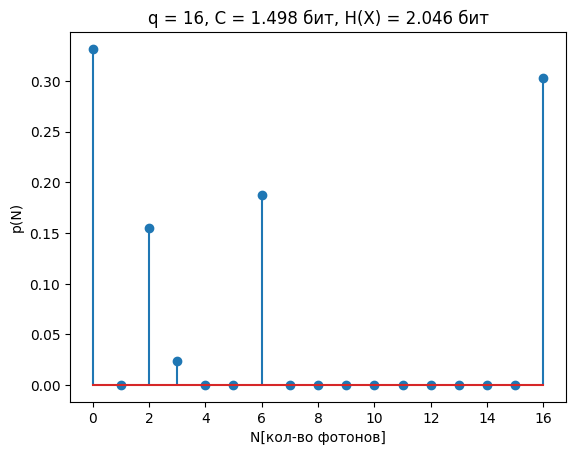

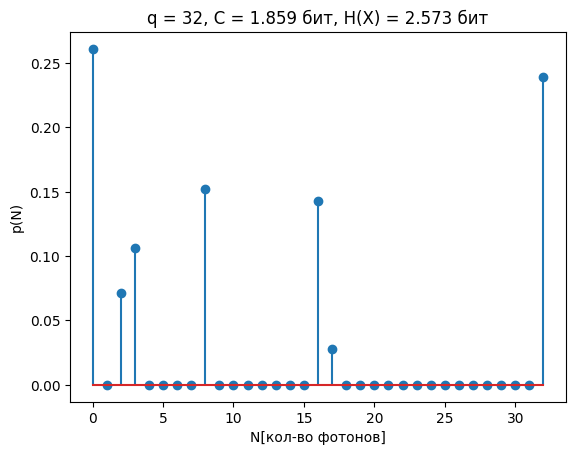

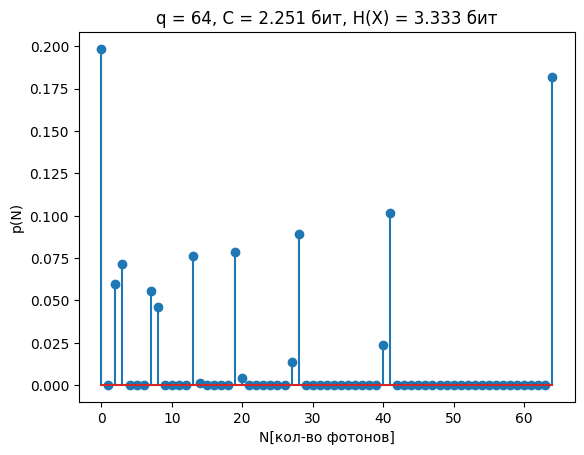

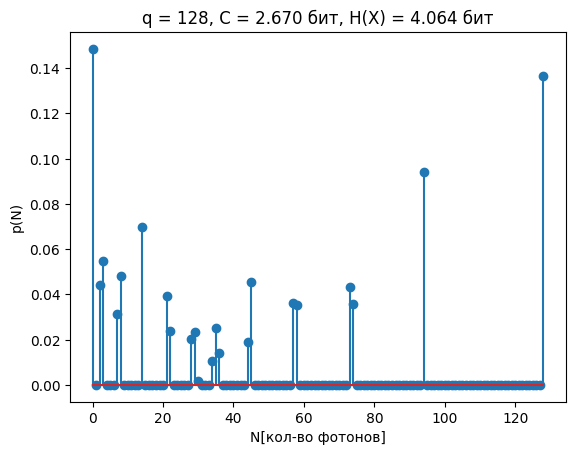

In [86]:
import matplotlib.pyplot as plt

for power in range(4, 8):
    channel = PoissonChannel(2**power)
    N = channel.q + 1
    C, X_opt = channel.get_C()
    plt.xlabel("N[кол-во фотонов]")
    plt.ylabel("p(N)")
    plt.title(f"q = {channel.q}, C = {C:.3f} бит, H(X) = {H(X_opt):.3f} бит")
    plt.stem([n for n in range(N)], X_opt.p)
    plt.show()

### дисктретный шум (X + N) mod q